# Implementación de un modelo de Deep Learning

> Datos Generales

Nombre: Edna Jacqueline Zavala Ortega

Matrícula: A01750480

> Dataset

El dataset contiene 15,000 imágenes de 3 clases de calzado: Botas, Sandalias y Zapatos casuales. Por ello, se realizó una CNN para clasificarlas.

El dataset se pre-procesó usando otro script y se crearon 3 conjuntos de datos: de entrenamiento, validación y pruebas.

El dataset original se puede encontrar en el siguiente enlace: https://www.kaggle.com/datasets/hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images

El notebook perteneciente al preprocesamiento de los datos se encuentra en el siguiente enlace: https://colab.research.google.com/drive/1KGqpqiWNWaASduHXivfvtkgdoF_hTpgo?usp=sharing y se puede encontrar una copia dentro del repositorio.

> Instalar e importar los módulos necesarios

In [ ]:
!pip install gdown

# to upgrade
!pip install --upgrade gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-4.5.3-py3-none-any.whl size=14840 sha256=8ddcbe155e668f79604a04116b330671fc18e2e6f66a0f3bfd2a058b56a6bee1
  Stored in directory: /root/.cache/pip/wheels/94/8d/0b/bdcd83555c3555f91a33f6c2384428d9f163c7d75ab0d272b4
Successfully built gdown
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [1]:
import cv2
import os.path
from os import path
import numpy as np
import os, pathlib
import pandas as pd
from tensorflow import keras
import tensorflow as tf
from keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import array_to_img
from tensorflow.keras.preprocessing import image_dataset_from_directory

%matplotlib inline

> Descargar el dataset

In [2]:
!gdown https://drive.google.com/uc?id=1-ATBfqegBu8jHhlTFB8C5RWBCnhO0mq2

Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1-ATBfqegBu8jHhlTFB8C5RWBCnhO0mq2 



In [3]:
!unzip -qq 'dataset-a01750480.zip'

> Cargar el dataset desde el directorio

In [4]:
# Tensorflow <2.10 use
current_directory = '/content/dataset-a01750480/content/drive/Shareddrives/Concentracion/Bloque II/Momento de Retroalimentacion/Deep Learning/Dataset'

# Definir el tamaño de las imágenes, el tamaño del batch y definir el directorio base
new_base_dir = pathlib.Path(current_directory)
image_size = (255,255)
batch_size = 16 # Múltiplos de 8

# Esta lista controlará el orden de las clases (mismo orden alfanumérico)
class_names = ["Boot", "Sandal", "Shoe"]

# Train dataset
# Se navega al directorio y se extraen los archivos, se cambia el tamaño y se realiza el one hot encoding de los labels
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=image_size,
    labels="inferred",
    label_mode="categorical",
    shuffle=True,
    batch_size=batch_size)

# Validation dataset
validation_dataset = image_dataset_from_directory(
    new_base_dir / "val",
    image_size=image_size,
    labels="inferred",
    label_mode="categorical",
    shuffle=True,
    batch_size=batch_size)

# Test dataset
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=image_size,
    labels="inferred",
    label_mode="categorical",
    shuffle=True,
    batch_size=batch_size)

Found 9600 files belonging to 3 classes.
Found 2400 files belonging to 3 classes.
Found 3000 files belonging to 3 classes.


In [5]:
# Diccionario para interpretar el resultado
class_decoder = {
    0: "Boot",
    1: "Sandal",
    2: "Shoe"
}

In [6]:
# Verificar que los datos se hayan cargado correctamente
for data_batch, labels_batch in train_dataset:
  print("data batch shape:", data_batch.shape)
  print(data_batch[0])
  print(labels_batch[0])
  print("labels batch shape:", labels_batch.shape)
  break

data batch shape: (16, 255, 255, 3)
tf.Tensor(
[[[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 ...

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]], shape=(255, 255, 3), dtype=float32)
tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
labels batch shape: (16, 3)


> CNN

Para la arquitectura se tienen principalmente los siguientes tipos de capas:

1. **Data Augmentation:** se tienen transformaciones como rotaciones, zoom, o se les da la vuelta a las imágenes.

2. **Rescaling:** se reescalan los valores de los pixeles de las imágenes a valores entre 0 y 1.

3. **Capas convolutivas:** tienen filtros cuyas dimensiones (kernel_size) son un hiperparámetro. Tienen la principal función de extraer los features.

4. **Max Pooling:** las capas de pooling reducen las dimensiones de los feature maps y resumen los features presentes en ellos, lo que hace que el modelo sea más resistente a cambios de posición en las imágenes. En el caso de max pooling se selecciona el elemento con un valor mayor dentro de la región del filtro. 

5. **Flatten:**reducir el tamaño del ouput para ser proce.

6. **Capas Densas:**se colocan al final de la arquitectura de la CNN y se conectan por completo a todas las neuronas de salida. Tiene la finalidad de clasificar la imagen. 

La función de activación es ReLu, la cual regresa la entrada si es positiva, de lo contrario, regresará cero. Esta función se ha caracterizado por obtener buenos resultados y ser fácil de entrenar.

Para la última capa densa se seleccionó la función de activación softmax, ya que al ser un problema de clasificación, se busca un vector de probabilidades.

**Hiperparámetros**

A) Tamaño del kernel: (3,3)

B) Pooling size (2,2)

C) epochs: 10

#### Primera Iteración

Selección de Hiperparámetros

In [51]:
# Tamaño de los filtros (kernel_size) para las capas convolutivas                                                                                                                                                                                   
kernel_size=(3,3) # Se suelen usar de tamaño 3,5,7
# Tamamos batches de 2x2 para disminuir la informacion obtenida del Conv2D                                                                                                                                                                                  
pool_size=(2, 2) 

Definir la Arquitectura

In [52]:
first_model = keras.Sequential([keras.Input(shape=(255, 255, 3)),
                          # Data Augmentation
                          layers.RandomFlip(),
                          layers.RandomRotation(0.1),
                          layers.RandomZoom(0.2),
                          # Rescale Input to values between 0 and 1
                          layers.Rescaling(1./255),
                          # Convolutional and Pooling Layers
                          # Para esta arquitectura se utiliza un mayor número de filtros a menor número de filtros
                          layers.Conv2D(filters=256, kernel_size=kernel_size, padding = 'same', activation="relu"),
                          layers.Conv2D(filters=256, kernel_size=kernel_size, padding = 'same', activation="relu"),
                          layers.MaxPooling2D(pool_size=pool_size),
                          layers.Conv2D(filters=64, kernel_size=kernel_size, padding = 'same', activation="relu"),
                          layers.Conv2D(filters=64, kernel_size=kernel_size, padding = 'same', activation="relu"),
                          layers.MaxPooling2D(pool_size=pool_size),
                          layers.Conv2D(filters=64, kernel_size=kernel_size, padding = 'same', activation="relu"),
                          layers.Conv2D(filters=64, kernel_size=kernel_size, padding = 'same', activation="relu"),
                          layers.MaxPooling2D(pool_size=pool_size),
                          layers.Conv2D(filters=32, kernel_size=kernel_size, padding = 'same', activation="relu"),
                          layers.Conv2D(filters=32, kernel_size=kernel_size, padding = 'same', activation="relu"),
                          layers.MaxPooling2D(pool_size=pool_size),
                          layers.Dropout(0.4),
                          # Flatten to enter Dense Layers
                          layers.Flatten(),
                          # Dense Layers: se debe considerar que el número de salidas es > 3000
                          keras.layers.Dense(100, activation ='relu'),
                          keras.layers.Dense(50, activation ='relu'),
                          # Output Layer
                          keras.layers.Dense(3, activation ='softmax')])
first_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_1 (RandomFlip)  (None, 255, 255, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 255, 255, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_1 (RandomZoom)  (None, 255, 255, 3)       0         
                                                                 
 rescaling_6 (Rescaling)     (None, 255, 255, 3)       0         
                                                                 
 conv2d_48 (Conv2D)          (None, 255, 255, 256)     7168      
                                                                 
 conv2d_49 (Conv2D)          (None, 255, 255, 256)     590080    
                                                      

Definir el optimizador, métricas y función de pérdida

In [53]:
# Optimizador: ADAM con learning rate 0.1
opt = tf.keras.optimizers.Adam(learning_rate=0.1) 
# Metricas: categorical accuracy y AUC
cat_accuracy = tf.keras.metrics.CategoricalAccuracy()
auc = tf.keras.metrics.AUC()
# Compilar el modelo y definir como función de pérdida categorical cross entropy
first_model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=[cat_accuracy, auc])

In [54]:
# Cambiar el directorio para guardar el callback en el entorno de ejecución y evitar la latencia de la conexión con Google Drive
os.chdir('/content/')
!ls

classic_architecture_model_auc.png	     final-model-history.csv
classic_architecture_model_cat_accuracy.png  final_model.keras
classic-architecture-model-history.csv	     final_model_loss.png
classic_architecture_model.keras	     predictions
classic_architecture_model_loss.png	     resnet_auc.png
dataset-a01750480			     resnet_cat_accuracy.png
dataset-a01750480.zip			     resnet-history.csv
drive					     resnet.keras
final_model_auc.png			     resnet_loss.png
final_model_cat_accuracy.png		     sample_data


Entrenar el modelo

In [55]:
# Cantidad de epochs
epochs=100
# Callbacks que monitorean el valor de la función de pérdida en el conjunto de validación
callbacks_first = [
    # Guarda el mejor modelo considerando que la función de pérdida en el conjunto de validación debe ser la mínima
    keras.callbacks.ModelCheckpoint(
        filepath="first_model.keras",
        save_best_only=True,
        monitor="val_loss",
        mode="min"),
    # Detiene el entrenamiento si el valor de la función de pérdida no decrece en un máximo de 2 epochs
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta = 0.0001,
        patience=3,
        mode="min",
        restore_best_weights=True)
]
# Entrenar la CNN
with tf.device('/device:GPU:0'):
  history = first_model.fit(
      train_dataset,
      epochs=epochs,
      validation_data=validation_dataset,
      callbacks=callbacks_first)

Epoch 1/100
600/600 [==============================] - 531s 868ms/step - loss: 245473424.0000 - categorical_accuracy: 0.3332 - auc_5: 0.4944 - val_loss: 1.1056 - val_categorical_accuracy: 0.3333 - val_auc_5: 0.5000
Epoch 2/100
600/600 [==============================] - 523s 871ms/step - loss: 1.1074 - categorical_accuracy: 0.3282 - auc_5: 0.4959 - val_loss: 1.1013 - val_categorical_accuracy: 0.3333 - val_auc_5: 0.5000
Epoch 3/100
600/600 [==============================] - 522s 870ms/step - loss: 1.1081 - categorical_accuracy: 0.3279 - auc_5: 0.4947 - val_loss: 1.0987 - val_categorical_accuracy: 0.3333 - val_auc_5: 0.5000
Epoch 4/100
600/600 [==============================] - 523s 871ms/step - loss: 1.1071 - categorical_accuracy: 0.3321 - auc_5: 0.4941 - val_loss: 1.1045 - val_categorical_accuracy: 0.3333 - val_auc_5: 0.5000
Epoch 5/100
600/600 [==============================] - 523s 871ms/step - loss: 1.1089 - categorical_accuracy: 0.3294 - auc_5: 0.4957 - val_loss: 1.1048 - val_catego

Se puede observar que en este caso, el entrenamiento terminó en la cuarta epoch dado que el valor de la función de pérdida en el conjunto de validación no disminuyó respecto al menor valor en 2 epochs consecutivas.

Es decir, el menor valor es el de la epoch 2 y en las siguientes epochs su valor no disminuyó.

Además, este modelo tiene un accuracy de 0.33 en el conjunto de validación, lo que indica **underfitting**.

In [66]:
# Convertir el diccionario de history.history dict a un DataFrame:    
first_model_hist_df = pd.DataFrame(history.history) 

# Guardar el DataFrame en un csv para reproducir las gráficas:
hist_csv_file = 'first-model-history.csv'
with open(hist_csv_file, mode='w') as f:
    first_model_hist_df.to_csv(f)

first_model_hist_df.rename(columns={"auc_5": "auc", "val_auc_5": "val_auc"}, inplace=True)
first_model_hist_df.head()

,loss,categorical_accuracy,auc,val_loss,val_categorical_accuracy,val_auc
0,2.454734e+08,0.333229,0.494354,1.105580,0.333333,0.5
1,1.107418e+00,0.328229,0.495942,1.101320,0.333333,0.5
2,1.108080e+00,0.327917,0.494688,1.098691,0.333333,0.5
3,1.107126e+00,0.332083,0.494053,1.104536,0.333333,0.5
4,1.108885e+00,0.329375,0.495670,1.104782,0.333333,0.5


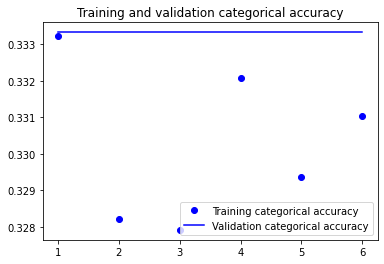

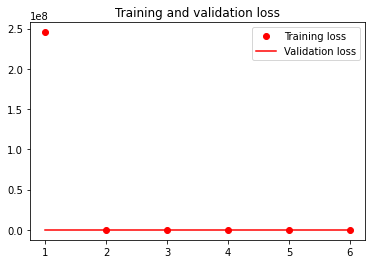

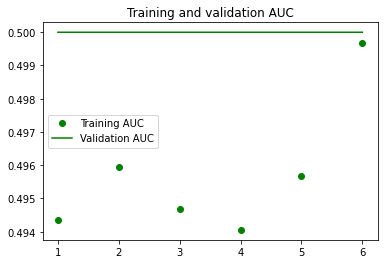

In [67]:
# Métricas del entrenamiento
train_cat_accuracy = first_model_hist_df["categorical_accuracy"]
train_loss = first_model_hist_df["loss"]
train_auc = first_model_hist_df["auc"]

# Métricas del conjunto de validación
val_cat_accuracy = first_model_hist_df["val_categorical_accuracy"]
val_loss = first_model_hist_df["val_loss"]
val_auc = first_model_hist_df["val_auc"]

# Generar una lista para graficar los valores respecto a las épocas
epochs = range(1, len(train_cat_accuracy) + 1)

# Categorical accuracy del conjunto de entrenamiento vs validación
plt.figure(1)
plt.plot(epochs, train_cat_accuracy, "bo", label="Training categorical accuracy")
plt.plot(epochs, val_cat_accuracy, "b", label="Validation categorical accuracy")
plt.title("Training and validation categorical accuracy")
plt.legend()
plt.savefig("first_model_cat_accuracy.png")


# Loss del conjunto de entrenamiento vs validación
plt.figure(2)
plt.plot(epochs, train_loss, "ro", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.savefig("first_model_loss.png")

# AUC del conjunto de entrenamiento vs validación
plt.figure(3)
plt.plot(epochs, train_auc, "go", label="Training AUC")
plt.plot(epochs, val_auc, "g", label="Validation AUC")
plt.title("Training and validation AUC")
plt.legend()
plt.savefig("first_model_auc.png")
plt.show()

Análisis de las métricas y gráficas

1. El valor para el **loss** en el conjunto de entrenamiento y validación permanece estable, es decir, no varía mucho entre epochs ni disminuye. Lo que significa que no se logró optimizarlo lo suficiente. Posiblemente, se deba ajustar el learning rate.

2. Además, el **accuracy** es sumamente bajo. Esto se puede interpretar como que el modelo aún no terminó de extraer los suficientes features para clasificar las imágenes.

3. El **AUC** nos permite saber si el modelo es capaz de distinguir entre clases. Entre más cercano a 1, significa que el modelo es mejor. En esta ocasión, no es muy cercano a 1.

4. En las gráficas, se pueden observar que el **loss** entre los conjuntos de **entrenamiento y validación** se encuentran muy separados. Así como el **accuracy** y el **AUC**. Esta es una clara señal de **underfitting**.


#### Segunda Iteración

De acuerdo con el primer resultado, se hicieron los siguientes cambios:
* Se retiraron las capas de data augmentation (ya que generaban demasiado ruido al modelo).

* Se cambió el número de filtros por un número menor, pues dado que el tamaño de la imagen era de 255x255 los filtros se estaban encimando mucho.

* Se disminuyó el learning rate del optimizador Adam. Cambió de 0.1 a 0.001

* Se agregó dropout del 40% de las neuronas entre las capas densas.

* Se aumentó el número de neuronas de las capas densas (100-> 2000, 50-> 1000).

Selección de Hiperparámetros

In [9]:
# Tamaño de los filtros (kernel_size) para las capas convolutivas                                                                                                                                                                                   
kernel_size=(3,3) # Se suelen usar de tamaño 3,5,7
# Tamamos batches de 2x2 para disminuir la informacion obtenida del Conv2D                                                                                                                                                                                  
pool_size=(2, 2) 

Definir la Arquitectura

In [10]:
final_model = keras.Sequential([keras.Input(shape=(255, 255, 3)),
                          # Rescale Input to values between 0 and 1
                          layers.Rescaling(1./255),
                          # Convolutional and Pooling Layers
                          # Para esta arquitectura se utiliza un mayor número de filtros a menor número de filtros
                          layers.Conv2D(filters=120, kernel_size=kernel_size, padding = 'same', activation="relu"),
                          layers.Conv2D(filters=120, kernel_size=kernel_size, padding = 'same', activation="relu"),
                          layers.MaxPooling2D(pool_size=pool_size),
                          layers.Conv2D(filters=60, kernel_size=kernel_size, padding = 'same', activation="relu"),
                          layers.Conv2D(filters=60, kernel_size=kernel_size, padding = 'same', activation="relu"),
                          layers.MaxPooling2D(pool_size=pool_size),
                          layers.Conv2D(filters=30, kernel_size=kernel_size, padding = 'same', activation="relu"),
                          layers.Conv2D(filters=30, kernel_size=kernel_size, padding = 'same', activation="relu"),
                          layers.MaxPooling2D(pool_size=pool_size),
                          layers.Conv2D(filters=15, kernel_size=kernel_size, padding = 'same', activation="relu"),
                          layers.Conv2D(filters=15, kernel_size=kernel_size, padding = 'same', activation="relu"),
                          layers.MaxPooling2D(pool_size=pool_size),
                          layers.Dropout(0.4),
                          # Flatten to enter Dense Layers
                          layers.Flatten(),
                          # Dense Layers: se debe considerar que el número de salidas es > 3000
                          keras.layers.Dense(2000, activation ='relu'),
                          # Dropout para procurar que las neuronas generalicen y se diferencíen entre sí para aprender más sobre diversos features de las imágenes
                          layers.Dropout(0.4),
                          keras.layers.Dense(1000, activation ='relu'),
                          # Dropout
                          layers.Dropout(0.4),
                          # Output Layer
                          keras.layers.Dense(3, activation ='softmax')])
final_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 255, 255, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 255, 255, 120)     3360      
                                                                 
 conv2d_9 (Conv2D)           (None, 255, 255, 120)     129720    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 127, 127, 120)    0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 127, 127, 60)      64860     
                                                                 
 conv2d_11 (Conv2D)          (None, 127, 127, 60)      32460     
                                                      

Definir el optimizador, métricas y función de pérdida

In [11]:
# Optimizador: ADAM con learning rate 0.001
opt = tf.keras.optimizers.Adam(learning_rate=0.001) 
# Metricas: categorical accuracy y AUC
cat_accuracy = tf.keras.metrics.CategoricalAccuracy()
auc = tf.keras.metrics.AUC()
# Compilar el modelo y definir como función de pérdida categorical cross entropy
final_model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=[cat_accuracy, auc])

In [12]:
# Cambiar el directorio para guardar el callback en el entorno de ejecución y evitar la latencia de la conexión con Google Drive
os.chdir('/content/')
!ls

dataset-a01750480  dataset-a01750480.zip  sample_data


Entrenar el modelo

In [13]:
# Cantidad de epochs
epochs=100

# Callbacks que monitorean el valor de la función de pérdida en el conjunto de validación
callbacks = [
    # Guarda el mejor modelo considerando que la función de pérdida en el conjunto de validación debe ser la mínima
    keras.callbacks.ModelCheckpoint(
        filepath="final_model.keras",
        save_best_only=True,
        monitor="val_loss",
        mode="min"),
    # Detiene el entrenamiento si el valor de la función de pérdida no decrece en un máximo de 3 epochs
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta = 0.0001,
        patience=3,
        mode="min",
        restore_best_weights=True)
]
# Entrenar la CNN
with tf.device('/device:GPU:0'):
  history = final_model.fit(
      train_dataset,
      epochs=epochs,
      validation_data=validation_dataset,
      callbacks=callbacks)

Epoch 1/100
600/600 [==============================] - 163s 248ms/step - loss: 0.4201 - categorical_accuracy: 0.8330 - auc: 0.9539 - val_loss: 0.2457 - val_categorical_accuracy: 0.9013 - val_auc: 0.9826
Epoch 2/100
600/600 [==============================] - 150s 249ms/step - loss: 0.2225 - categorical_accuracy: 0.9237 - auc: 0.9854 - val_loss: 0.2990 - val_categorical_accuracy: 0.8938 - val_auc: 0.9763
Epoch 3/100
600/600 [==============================] - 150s 250ms/step - loss: 0.1701 - categorical_accuracy: 0.9399 - auc: 0.9908 - val_loss: 0.2064 - val_categorical_accuracy: 0.9475 - val_auc: 0.9867
Epoch 4/100
600/600 [==============================] - 150s 250ms/step - loss: 0.1534 - categorical_accuracy: 0.9457 - auc: 0.9924 - val_loss: 0.1454 - val_categorical_accuracy: 0.9533 - val_auc: 0.9933
Epoch 5/100
600/600 [==============================] - 150s 250ms/step - loss: 0.1082 - categorical_accuracy: 0.9605 - auc: 0.9961 - val_loss: 0.1447 - val_categorical_accuracy: 0.9542 - v

In [14]:
# convert the history.history dict to a pandas DataFrame:     
final_model_hist_df = pd.DataFrame(history.history) 

# or save to csv: 
hist_csv_file = 'final-model-history.csv'
with open(hist_csv_file, mode='w') as f:
    final_model_hist_df .to_csv(f)

final_model_hist_df.head()

,loss,categorical_accuracy,auc,val_loss,val_categorical_accuracy,val_auc
0,0.420117,0.833021,0.953895,0.245656,0.901250,0.982642
1,0.222519,0.923750,0.985442,0.298958,0.893750,0.976258
2,0.170139,0.939896,0.990839,0.206383,0.947500,0.986690
3,0.153363,0.945729,0.992436,0.145429,0.953333,0.993311
4,0.108219,0.960521,0.996081,0.144724,0.954167,0.993377


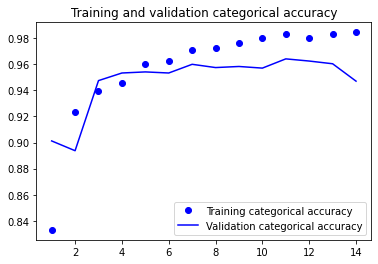

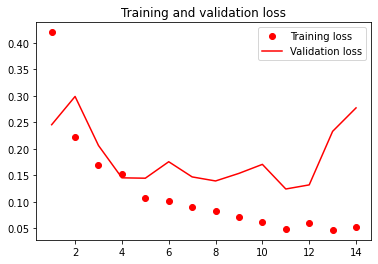

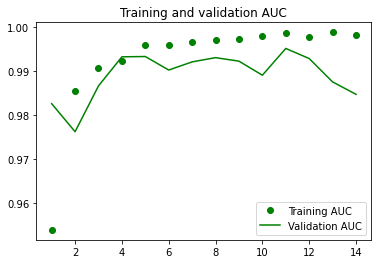

In [15]:
final_model_hist_df = pd.read_csv('final-model-history.csv')
# Renombrar columnas para crear las gráficas
final_model_hist_df.rename(columns={"auc_1": "auc", "val_auc_1": "val_auc"}, inplace=True)

# Métricas del entrenamiento
train_cat_accuracy = final_model_hist_df["categorical_accuracy"]
train_loss = final_model_hist_df["loss"]
train_auc = final_model_hist_df["auc"]

# Métricas del conjunto de validación
val_cat_accuracy = final_model_hist_df["val_categorical_accuracy"]
val_loss = final_model_hist_df["val_loss"]
val_auc = final_model_hist_df["val_auc"]

# Generar una lista para graficar los valores respecto a las épocas
epochs = range(1, len(train_cat_accuracy) + 1)

# Categorical accuracy del conjunto de entrenamiento vs validación
plt.figure(1)
plt.plot(epochs, train_cat_accuracy, "bo", label="Training categorical accuracy")
plt.plot(epochs, val_cat_accuracy, "b", label="Validation categorical accuracy")
plt.title("Training and validation categorical accuracy")
plt.legend()
plt.savefig("final_model_cat_accuracy.png")

# Loss del conjunto de entrenamiento vs validación
plt.figure(2)
plt.plot(epochs, train_loss, "ro", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.savefig("final_model_loss.png")

# AUC del conjunto de entrenamiento vs validación
plt.figure(3)
plt.plot(epochs, train_auc, "go", label="Training AUC")
plt.plot(epochs, val_auc, "g", label="Validation AUC")
plt.title("Training and validation AUC")
plt.legend()
plt.savefig("final_model_auc.png")
plt.show()

Análisis de las métricas y gráficas

1. El valor para el **loss** en el conjunto de entrenamiento y validación es muy bajo y se observa que entre epochs ha disminuido de forma gradual.

2. Además, el **accuracy** es alto y fue incrementando su valor en cada epoch.

3. El **AUC** es muy cercano a 1.

4. En las gráficas, se pueden observar que las curvas para **loss** entre los conjuntos de **entrenamiento y validación** se encuentran muy cercanas. Así como el **accuracy** y el **AUC**. Sin embargo, en las últimas épocas se comienzan a separar, lo que podría implicar el inicio del **overfitting** del modelo. 

Para esto último, fue que se incluyó en los **callbacks que se guardaría el mejor modelo con el loss más bajo**. Por ello, se puede pensar que se guardó el modelo de la epoch 6.

#### Tercera Iteración: Arquitectura convencional

El principal cambio de este modelo respecto a la segunda iteración es la inversión de la cantidad de filtros de las capas de convolución (orden descendente a ascendente).

Selección de Hiperparámetros

In [30]:
# Tamaño de los filtros (kernel_size) para las capas convolutivas                                                                                                                                                                                   
kernel_size=(3,3) # Se suelen usar de tamaño 3,5,7
# Tamamos batches de 2x2 para disminuir la informacion obtenida del Conv2D                                                                                                                                                                                  
pool_size=(2, 2) 

Definir la Arquitectura

In [32]:
classic_architecture_model = keras.Sequential([keras.Input(shape=(255, 255, 3)),
                          # Rescale Input to values between 0 and 1
                          layers.Rescaling(1./255),
                          # Convolutional and Pooling Layers
                          # Para esta arquitectura se utiliza un mayor número de filtros a menor número de filtros
                          layers.Conv2D(filters=15, kernel_size=kernel_size, padding = 'same', activation="relu"),
                          layers.Conv2D(filters=15, kernel_size=kernel_size, padding = 'same', activation="relu"),
                          layers.MaxPooling2D(pool_size=pool_size),
                          layers.Conv2D(filters=30, kernel_size=kernel_size, padding = 'same', activation="relu"),
                          layers.Conv2D(filters=30, kernel_size=kernel_size, padding = 'same', activation="relu"),
                          layers.MaxPooling2D(pool_size=pool_size),
                          layers.Conv2D(filters=60, kernel_size=kernel_size, padding = 'same', activation="relu"),
                          layers.Conv2D(filters=60, kernel_size=kernel_size, padding = 'same', activation="relu"),
                          layers.MaxPooling2D(pool_size=pool_size),
                          layers.Conv2D(filters=120, kernel_size=kernel_size, padding = 'same', activation="relu"),
                          layers.Conv2D(filters=120, kernel_size=kernel_size, padding = 'same', activation="relu"),
                          layers.MaxPooling2D(pool_size=pool_size),
                          layers.Dropout(0.4),
                          # Flatten to enter Dense Layers
                          layers.Flatten(),
                          # Dense Layers: se debe considerar que el número de salidas es > 3000
                          keras.layers.Dense(2000, activation ='relu'),
                          # Dropout para procurar que las neuronas generalicen y se diferencíen entre sí para aprender más sobre diversos features de las imágenes
                          layers.Dropout(0.4),
                          keras.layers.Dense(1000, activation ='relu'),
                          # Dropout
                          layers.Dropout(0.4),
                          # Output Layer
                          keras.layers.Dense(3, activation ='softmax')])
classic_architecture_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 255, 255, 3)       0         
                                                                 
 conv2d_40 (Conv2D)          (None, 255, 255, 15)      420       
                                                                 
 conv2d_41 (Conv2D)          (None, 255, 255, 15)      2040      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 127, 127, 15)     0         
 g2D)                                                            
                                                                 
 conv2d_42 (Conv2D)          (None, 127, 127, 30)      4080      
                                                                 
 conv2d_43 (Conv2D)          (None, 127, 127, 30)      8130      
                                                      

Definir el optimizador, métricas y función de pérdida

In [33]:
# Optimizador: ADAM con learning rate 0.001
opt = tf.keras.optimizers.Adam(learning_rate=0.001) 
# Metricas: categorical accuracy y AUC
cat_accuracy = tf.keras.metrics.CategoricalAccuracy()
auc = tf.keras.metrics.AUC()
# Compilar el modelo y definir como función de pérdida categorical cross entropy
classic_architecture_model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=[cat_accuracy, auc])

In [34]:
# Cambiar el directorio para guardar el callback en el entorno de ejecución y evitar la latencia de la conexión con Google Drive
os.chdir('/content/')
!ls

classic_architecture_model_auc.png	     drive
classic_architecture_model_cat_accuracy.png  final_model_auc.png
classic-architecture-model-history.csv	     final_model_cat_accuracy.png
classic_architecture_model.keras	     final-model-history.csv
classic_architecture_model_loss.png	     final_model.keras
dataset-a01750480			     final_model_loss.png
dataset-a01750480.zip			     sample_data


Entrenar el modelo

In [35]:
# Cantidad de epochs
epochs=100

# Callbacks que monitorean el valor de la función de pérdida en el conjunto de validación
callbacks = [
    # Guarda el mejor modelo considerando que la función de pérdida en el conjunto de validación debe ser la mínima
    keras.callbacks.ModelCheckpoint(
        filepath="classic_architecture_model.keras",
        save_best_only=True,
        monitor="val_loss",
        mode="min"),
    # Detiene el entrenamiento si el valor de la función de pérdida no decrece en un máximo de 3 epochs
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta = 0.0001,
        patience=3,
        mode="min",
        restore_best_weights=True)
]
# Entrenar la CNN
with tf.device('/device:GPU:0'):
  history = classic_architecture_model.fit(
      train_dataset,
      epochs=epochs,
      validation_data=validation_dataset,
      callbacks=callbacks)

Epoch 1/100
600/600 [==============================] - 50s 80ms/step - loss: 0.4174 - categorical_accuracy: 0.8274 - auc_3: 0.9537 - val_loss: 0.2418 - val_categorical_accuracy: 0.9142 - val_auc_3: 0.9822
Epoch 2/100
600/600 [==============================] - 46s 77ms/step - loss: 0.1918 - categorical_accuracy: 0.9333 - auc_3: 0.9885 - val_loss: 0.1917 - val_categorical_accuracy: 0.9354 - val_auc_3: 0.9899
Epoch 3/100
600/600 [==============================] - 47s 78ms/step - loss: 0.1450 - categorical_accuracy: 0.9490 - auc_3: 0.9933 - val_loss: 0.1242 - val_categorical_accuracy: 0.9600 - val_auc_3: 0.9944
Epoch 4/100
600/600 [==============================] - 45s 74ms/step - loss: 0.1194 - categorical_accuracy: 0.9606 - auc_3: 0.9947 - val_loss: 0.1546 - val_categorical_accuracy: 0.9542 - val_auc_3: 0.9910
Epoch 5/100
600/600 [==============================] - 47s 78ms/step - loss: 0.1040 - categorical_accuracy: 0.9642 - auc_3: 0.9957 - val_loss: 0.1042 - val_categorical_accuracy: 0.

In [36]:
# convert the history.history dict to a pandas DataFrame:     
classic_architecture_model_hist_df = pd.DataFrame(history.history) 

# or save to csv: 
hist_csv_file = 'classic-architecture-model-history.csv'
with open(hist_csv_file, mode='w') as f:
    classic_architecture_model_hist_df .to_csv(f)

classic_architecture_model_hist_df.head()

,loss,categorical_accuracy,auc_3,val_loss,val_categorical_accuracy,val_auc_3
0,0.417403,0.827396,0.953712,0.241761,0.914167,0.982217
1,0.191785,0.933333,0.988495,0.191650,0.935417,0.989904
2,0.144952,0.948958,0.993276,0.124153,0.960000,0.994380
3,0.119373,0.960625,0.994710,0.154610,0.954167,0.990965
4,0.104044,0.964167,0.995675,0.104159,0.968750,0.995761


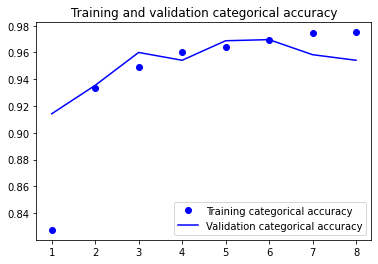

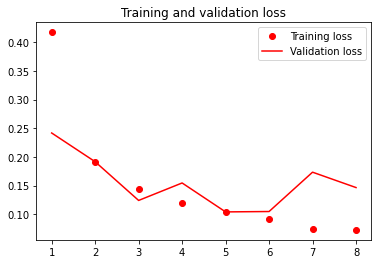

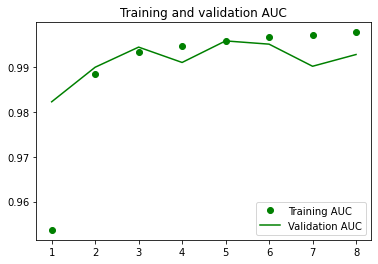

In [37]:
classic_architecture_model_hist_df = pd.read_csv('classic-architecture-model-history.csv')
# Renombrar columnas para crear las gráficas
classic_architecture_model_hist_df.rename(columns={"auc_3": "auc", "val_auc_3": "val_auc"}, inplace=True)

# Métricas del entrenamiento
train_cat_accuracy = classic_architecture_model_hist_df["categorical_accuracy"]
train_loss = classic_architecture_model_hist_df["loss"]
train_auc = classic_architecture_model_hist_df["auc"]

# Métricas del conjunto de validación
val_cat_accuracy = classic_architecture_model_hist_df["val_categorical_accuracy"]
val_loss = classic_architecture_model_hist_df["val_loss"]
val_auc = classic_architecture_model_hist_df["val_auc"]

# Generar una lista para graficar los valores respecto a las épocas
epochs = range(1, len(train_cat_accuracy) + 1)

# Categorical accuracy del conjunto de entrenamiento vs validación
plt.figure(1)
plt.plot(epochs, train_cat_accuracy, "bo", label="Training categorical accuracy")
plt.plot(epochs, val_cat_accuracy, "b", label="Validation categorical accuracy")
plt.title("Training and validation categorical accuracy")
plt.legend()
plt.savefig("classic_architecture_model_cat_accuracy.png")

# Loss del conjunto de entrenamiento vs validación
plt.figure(2)
plt.plot(epochs, train_loss, "ro", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.savefig("classic_architecture_model_loss.png")

# AUC del conjunto de entrenamiento vs validación
plt.figure(3)
plt.plot(epochs, train_auc, "go", label="Training AUC")
plt.plot(epochs, val_auc, "g", label="Validation AUC")
plt.title("Training and validation AUC")
plt.legend()
plt.savefig("classic_architecture_model_auc.png")
plt.show()

Análisis de las métricas y gráficas

1. El valor para el **loss** en el conjunto de entrenamiento y validación disminuye tras cada epoch.

2. Además, se alcanza un **accuracy** de hasta 0.97 en el conjunto de validación. 

3. El **AUC** nos permite saber si el modelo es capaz de distinguir entre clases. Entre más cercano a 1, significa que el modelo es mejor. En esta ocasión, es muy cercano a 1 y permanece estable en cada epoch (aprox. 0.99).

4. En las gráficas, se pueden observar que la curva del **loss** entre los conjuntos de **entrenamiento y validación** disminuyen juntas aunque en la última epoch comenzaban a separarse. El **accuracy** incrementa en cada epoch para ambos conjuntos, así como el **AUC**. Estas son métricas que indican que es un buen modelo.


#### Transfer Learning: ResNet50

Residual Networks (ResNet para abreviar) fue introducida por Microsoft Research en 2015.



Arquitectura

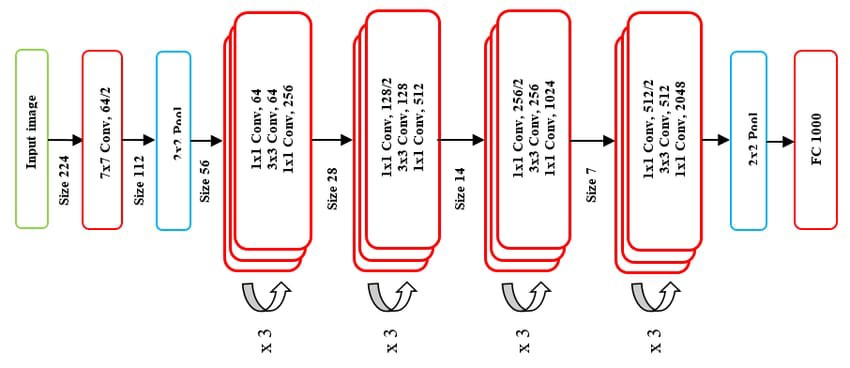

En esta ocasión, se utilizará una ResNet50 entrenada previamente con el dataset **imagenet**. Esta red, como su nombre lo indica, trabaja con 50 capas.

ImageNet es una base de datos de imágenes organizada según la jerarquía de WordNet, en la que cada nodo de la jerarquía está representado por cientos y miles de imágenes.

In [38]:
# Crear un Sequential para agregar las capas finales y procesar la salida
resnet = Sequential()

# Precargar el modelo ResNet50
pretrained_model= tf.keras.applications.ResNet50(
    # include_top en False para agregar nuestro propio tamaño de entrada en input_shape
    include_top=False,
    input_shape=(255,255,3),
    # También se utilizará max pooling
    pooling='max',classes=3,
    # Usamos los pesos aprendidos con imagenet
    weights='imagenet')

# Indicar qu 
for layer in pretrained_model.layers:
        layer.trainable=False

# Agregamos a Sequential el modelo preentrenado
resnet.add(pretrained_model)
# A partir de aquí se utiliza la salida del mejor modelo de CNN
resnet.add(Flatten())
resnet.add(Dense(1000, activation='relu'))
resnet.add(Dropout(0.4))
resnet.add(Dense(1000, activation='relu'))
resnet.add(Dropout(0.4))
resnet.add(Dense(3, activation='softmax'))

resnet.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_7 (Flatten)         (None, 2048)              0         
                                                                 
 dense_21 (Dense)            (None, 1000)              2049000   
                                                                 
 dropout_18 (Dropout)        (None, 1000)              0         
                                                                 
 dense_22 (Dense)            (None, 1000)              1001000   
                                                                 
 dropout_19 (Dropout)        (None, 1000)              0         
                                                                 
 dense_23 (Dense)            (None, 3)                

Se puede observar que de 26,640,715 parámetros solo se entrenarán 3,053,003, lo cual es una ventaja en términos de recursos.

In [39]:
# Optimizador: ADAM con learning rate 0.001
opt = tf.keras.optimizers.Adam(learning_rate=0.001) 
# Metricas: categorical accuracy y AUC
cat_accuracy = tf.keras.metrics.CategoricalAccuracy()
auc = tf.keras.metrics.AUC()

# Compilar el modelo
resnet.compile(optimizer=opt,loss='categorical_crossentropy',metrics=[cat_accuracy, auc])

# Callbacks que monitorean el valor de la función de pérdida en el conjunto de validación
resnet_callbacks = [
    # Guarda el mejor modelo considerando que la función de pérdida en el conjunto de validación debe ser la mínima
    keras.callbacks.ModelCheckpoint(
        filepath="resnet.keras",
        save_best_only=True,
        monitor="val_loss",
        mode="min"),
    # Detiene el entrenamiento si el valor de la función de pérdida no decrece en un máximo de 3 epochs
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta = 0.0001,
        patience=3,
        mode="min",
        restore_best_weights=True)
]

# Entrenar el modelo
history = resnet.fit(train_dataset, validation_data=validation_dataset, epochs=100, callbacks=resnet_callbacks)

Epoch 1/100
600/600 [==============================] - 58s 91ms/step - loss: 1.0537 - categorical_accuracy: 0.8660 - auc_4: 0.9458 - val_loss: 0.1586 - val_categorical_accuracy: 0.9421 - val_auc_4: 0.9919
Epoch 2/100
600/600 [==============================] - 54s 90ms/step - loss: 0.2805 - categorical_accuracy: 0.9082 - auc_4: 0.9799 - val_loss: 0.1375 - val_categorical_accuracy: 0.9529 - val_auc_4: 0.9938
Epoch 3/100
600/600 [==============================] - 53s 89ms/step - loss: 0.2335 - categorical_accuracy: 0.9187 - auc_4: 0.9852 - val_loss: 0.1592 - val_categorical_accuracy: 0.9417 - val_auc_4: 0.9935
Epoch 4/100
600/600 [==============================] - 54s 90ms/step - loss: 0.2449 - categorical_accuracy: 0.9173 - auc_4: 0.9845 - val_loss: 0.0970 - val_categorical_accuracy: 0.9654 - val_auc_4: 0.9968
Epoch 5/100
600/600 [==============================] - 54s 90ms/step - loss: 0.2239 - categorical_accuracy: 0.9281 - auc_4: 0.9862 - val_loss: 0.0934 - val_categorical_accuracy: 0.

In [40]:
# convert the history.history dict to a pandas DataFrame:     
resnet_hist_df = pd.DataFrame(history.history) 

# or save to csv: 
hist_csv_file = 'resnet-history.csv'
with open(hist_csv_file, mode='w') as f:
    resnet_hist_df.to_csv(f)

resnet_hist_df.head()

,loss,categorical_accuracy,auc_4,val_loss,val_categorical_accuracy,val_auc_4
0,1.053668,0.866042,0.945840,0.158570,0.942083,0.991947
1,0.280529,0.908229,0.979940,0.137455,0.952917,0.993839
2,0.233548,0.918750,0.985207,0.159248,0.941667,0.993532
3,0.244927,0.917292,0.984523,0.097042,0.965417,0.996806
4,0.223900,0.928125,0.986202,0.093433,0.968750,0.997457


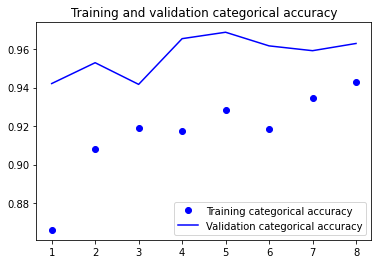

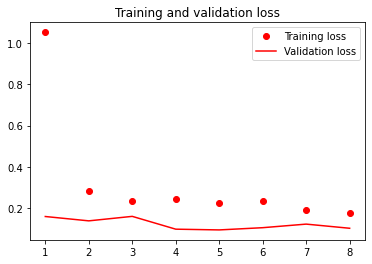

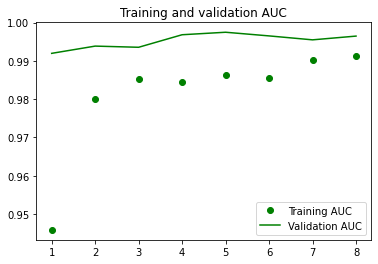

In [42]:
resnet_hist_df = pd.read_csv('resnet-history.csv')
# Renombrar columnas para crear las gráficas
resnet_hist_df.rename(columns={"auc_4": "auc", "val_auc_4": "val_auc"}, inplace=True)

# Métricas del entrenamiento
train_cat_accuracy = resnet_hist_df["categorical_accuracy"]
train_loss = resnet_hist_df["loss"]
train_auc = resnet_hist_df["auc"]

# Métricas del conjunto de validación
val_cat_accuracy = resnet_hist_df["val_categorical_accuracy"]
val_loss = resnet_hist_df["val_loss"]
val_auc = resnet_hist_df["val_auc"]

# Generar una lista para graficar los valores respecto a las épocas
epochs = range(1, len(train_cat_accuracy) + 1)

# Categorical accuracy del conjunto de entrenamiento vs validación
plt.figure(1)
plt.plot(epochs, train_cat_accuracy, "bo", label="Training categorical accuracy")
plt.plot(epochs, val_cat_accuracy, "b", label="Validation categorical accuracy")
plt.title("Training and validation categorical accuracy")
plt.legend()
plt.savefig("resnet_cat_accuracy.png")


# Loss del conjunto de entrenamiento vs validación
plt.figure(2)
plt.plot(epochs, train_loss, "ro", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.savefig("resnet_loss.png")

# AUC del conjunto de entrenamiento vs validación
plt.figure(3)
plt.plot(epochs, train_auc, "go", label="Training AUC")
plt.plot(epochs, val_auc, "g", label="Validation AUC")
plt.title("Training and validation AUC")
plt.legend()
plt.savefig("resnet_auc.png")
plt.show()

Análisis de las métricas y gráficas

1. El valor para el **loss** en el conjunto de entrenamiento y validación va disminuyendo de forma gradual.

2. Además, el **accuracy** se observa un poco inestable. Aún así fue incrementando su valor en cada epoch.

3. El **AUC** es muy cercano a 1.

4. En las gráficas, se pueden observar que las curvas para **loss** entre los conjuntos de **entrenamiento y validación** se encuentran muy cercanas pero hay puntos donde comienzan a separarse. En el **AUC**, las curvas también tienden a separarse pero es poco comparado con el **accuracy**. Aunque este último se muestra muy inestable entre epochs, los valores fueron incrementando.

Para esto último, fue que se incluyó en los **callbacks que se guardaría el mejor modelo con el loss más bajo en el conjunto de validación**.

#### Test Dataset

> Primer CNN

In [ ]:
# Path de donde se encuentra el modelo
model_path = '/content/first_model.keras'

# Cargar el modelo
first_test_model = keras.models.load_model(
    model_path)

# Proporcionar el conjunto de prueba al modelo
first_test_loss, first_test_acc, first_test_auc = first_test_model.evaluate(test_dataset)

print(f"Test Categorical accuracy: {first_test_acc:.3f}")
print(f"Test loss: {first_test_loss:.3f}")
print(f"Test AUC: {first_test_auc:.3f}")

188/188 [==============================] - 52s 275ms/step - loss: 1.0987 - categorical_accuracy: 0.3333 - auc: 0.5000
Test Categorical accuracy: 0.333
Test loss: 1.099
Test AUC: 0.500


> Mejor CNN

In [ ]:
# Path de donde se encuentra el modelo
model_path = '/content/final_model.keras'

# Cargar el modelo
final_test_model = keras.models.load_model(
    model_path)

# Proporcionar el conjunto de prueba al modelo
final_test_loss, final_test_acc, final_test_auc = final_test_model.evaluate(test_dataset)

print(f"Test Categorical accuracy: {final_test_acc:.3f}")
print(f"Test loss: {final_test_loss:.3f}")
print(f"Test AUC: {final_test_auc:.3f}")

188/188 [==============================] - 17s 89ms/step - loss: 0.0887 - categorical_accuracy: 0.9693 - auc_1: 0.9972
Test Categorical accuracy: 0.969
Test loss: 0.089
Test AUC: 0.997


> ResNet50

In [ ]:
# Path de donde se encuentra el modelo
model_path = '/content/resnet.keras'

# Cargar el modelo
resnet_test_model = keras.models.load_model(
    model_path)

# Proporcionar el conjunto de prueba al modelo
resnet_test_loss, resnet_test_acc, resnet_test_auc = resnet_test_model.evaluate(test_dataset)

print(f"Test Categorical accuracy: {resnet_test_acc:.3f}")
print(f"Test loss: {resnet_test_loss:.3f}")
print(f"Test AUC: {resnet_test_auc:.3f}")

188/188 [==============================] - 15s 71ms/step - loss: 0.0881 - categorical_accuracy: 0.9737 - auc_2: 0.9971
Test Categorical accuracy: 0.974
Test loss: 0.088
Test AUC: 0.997


#### Predicciones

In [43]:
# Función para preprocesar la imagen con cv2
dimensions = (255,255)
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image,dimensions)
    image = np.expand_dims(image, axis=0)
    return image

In [44]:
folder_directory = '/content/predictions'

prediction_images = os.listdir(folder_directory)

> Primer CNN

1/1 [==============================] - 0s 38ms/step


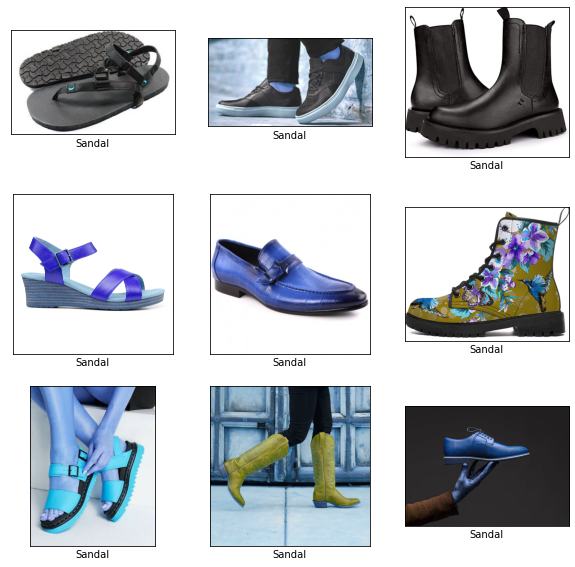

In [69]:
first_model_predictions=[]

# Iterar sobre las imágenes de predicción y guardar el resultado
for image in prediction_images:
  test_image = preprocess_image(os.path.join(folder_directory, image))
  prediction = first_model.predict(test_image)
  result = np.argmax(prediction)
  first_model_predictions.append(class_decoder[result])

# Mostrar resultados
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image = cv2.imread(os.path.join(folder_directory, prediction_images[i]))
    plt.imshow(image)
    plt.xlabel(first_model_predictions[i])
plt.show()

El resultado es muy inexacto, ya que el modelo no logró obtener suficientes features de cada clase.

> CNN

1/1 [==============================] - 0s 21ms/step
/content/predictions/sandals-2.jpg
/content/predictions/shoes-1.jpg
/content/predictions/boots-2.jpg
/content/predictions/sandals-1.jpeg
/content/predictions/shoes-2.jpeg
/content/predictions/boots-3.jpg
/content/predictions/sandals-3.jpg
/content/predictions/boots-1.jpg
/content/predictions/shoes-3.jpg


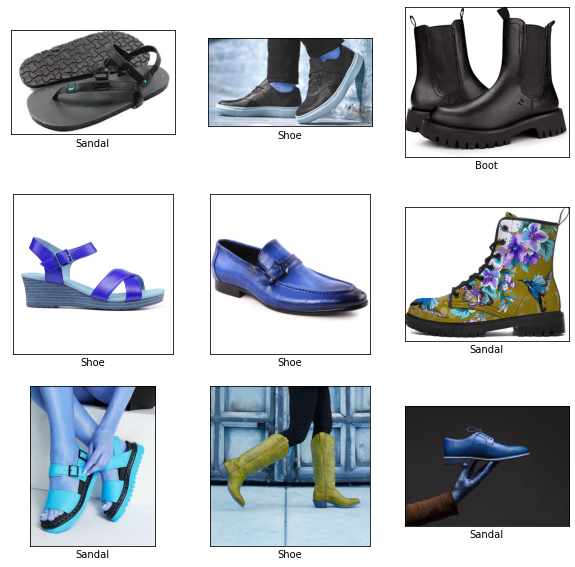

In [47]:
final_model_predictions=[]

# Iterar sobre las imágenes de predicción y guardar el resultado
for image in prediction_images:
  test_image = preprocess_image(os.path.join(folder_directory, image))
  prediction = final_model.predict(test_image)
  result = np.argmax(prediction)
  final_model_predictions.append(class_decoder[result])

# Mostrar resultados
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    print(os.path.join(folder_directory, prediction_images[i]))
    image = cv2.imread(os.path.join(folder_directory, prediction_images[i]))
    plt.imshow(image)
    plt.xlabel(final_model_predictions[i])
plt.show()

El resultado es bueno en imágenes con fondo blanco, sin embargo, al observar imágenes con ruido tiende a confundirse. 

Esto se debe a que en el dataset solo se incluyeron imágenes con el calzado sobre un fondo blanco.

Por lo tanto, este modelo tiene área de oportunidad al fortalecer el dataset. 

> Arquitectura clásica CNN (filtros en orden ascendente)

1/1 [==============================] - 0s 19ms/step
/content/predictions/sandals-2.jpg
/content/predictions/shoes-1.jpg
/content/predictions/boots-2.jpg
/content/predictions/sandals-1.jpeg
/content/predictions/shoes-2.jpeg
/content/predictions/boots-3.jpg
/content/predictions/sandals-3.jpg
/content/predictions/boots-1.jpg
/content/predictions/shoes-3.jpg


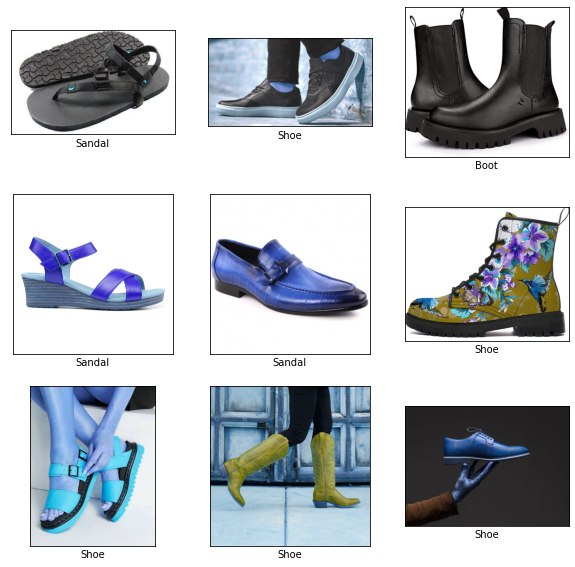

In [48]:
classic_architecture_model_predictions = []

# Iterar sobre las imágenes de predicción y guardar el resultado
for image in prediction_images:
  test_image = preprocess_image(os.path.join(folder_directory, image))
  prediction = classic_architecture_model.predict(test_image)
  result = np.argmax(prediction)
  classic_architecture_model_predictions.append(class_decoder[result])

# Mostrar resultados
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    print(os.path.join(folder_directory, prediction_images[i]))
    image = cv2.imread(os.path.join(folder_directory, prediction_images[i]))
    plt.imshow(image)
    plt.xlabel(classic_architecture_model_predictions[i])
plt.show()

Se puede observar que el modelo comenzaba a ser capaz de distinguir entre las clases. Para estos casos, se clasificó de forma errónea un zapato y una sandalia.

Por lo tanto, este modelo también tiene área de oportunidad al fortalecer el dataset. 

> ResNet 50

1/1 [==============================] - 0s 27ms/step
/content/predictions/sandals-2.jpg
/content/predictions/shoes-1.jpg
/content/predictions/boots-2.jpg
/content/predictions/sandals-1.jpeg
/content/predictions/shoes-2.jpeg
/content/predictions/boots-3.jpg
/content/predictions/sandals-3.jpg
/content/predictions/boots-1.jpg
/content/predictions/shoes-3.jpg


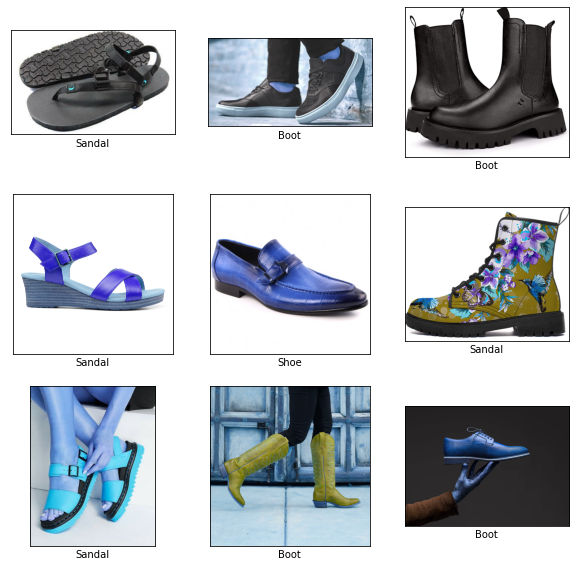

In [50]:
resnet_model_predictions = []

# Iterar sobre las imágenes de predicción y guardar el resultado
for image in prediction_images:
  test_image = preprocess_image(os.path.join(folder_directory, image))
  prediction = resnet.predict(test_image)
  result = np.argmax(prediction)
  resnet_model_predictions.append(class_decoder[result])

# Mostrar resultados
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    print(os.path.join(folder_directory, prediction_images[i]))
    image = cv2.imread(os.path.join(folder_directory, prediction_images[i]))
    plt.imshow(image)
    plt.xlabel(resnet_model_predictions[i])
plt.show()

Los pesos del modelo fueron obtenidos al entrenarlo con el set de 'imagenet', por lo que se observa que tiene una mejor capacidad de generalizar y de detectar el calzado en otros contextos. 

La única predicción incorrecta fue la segunda imagen de la primera fila (boots-> shoe).

Este modelo es mejor que el segundo y el tercero. Sin embargo, aún existe área de oportunidad dentro del dataset.